# Test our Ecohydrology module

This notebook is to test that importing and using our implementation of the Ecohydrology model works. 

In [1]:
from ecohydr_mod import EcoHyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_yearly_temp(csv_path, num_years):
    df = pd.read_csv(csv_path)
    df.dt = pd.to_datetime(df.dt)
    avg_temp_per_year = []
    max_temp_per_year = []
    min_temp_per_year = []
    for year in range(0, num_years):
        earliest_yr = df.iloc[0, 0].year
        year = year + earliest_yr
        if len(df.loc[(df.dt.dt.year == year), :]) > 365:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].iloc[:-1].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].iloc[:-1].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].iloc[:-1].tolist())
        else:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].tolist())
    
    return avg_temp_per_year, max_temp_per_year, min_temp_per_year

In [3]:
#get input temperature data
avg, maxi, mini = get_yearly_temp('new_temp_data.csv', 10)

In [4]:
WSA_array = np.zeros((51,51))
# Set 20 random values to 1
indices_to_set = np.random.choice(range(51 * 51), size=20, replace=False)
row_indices, col_indices = np.unravel_index(indices_to_set, (51, 51))
WSA_array[row_indices, col_indices] = int(1)

Ecohyd_model = EcoHyd(20, 26, 23)

In [5]:
def get_yearly_temp(csv_path, num_years):
    df = pd.read_csv(csv_path)
    df.dt = pd.to_datetime(df.dt)
    avg_temp_per_year = []
    max_temp_per_year = []
    min_temp_per_year = []
    for year in range(0, num_years):
        earliest_yr = df.iloc[0, 0].year
        year = year + earliest_yr
        if len(df.loc[(df.dt.dt.year == year), :]) > 365:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].iloc[:-1].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].iloc[:-1].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].iloc[:-1].tolist())
        else:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].tolist())
    
    return avg_temp_per_year, max_temp_per_year, min_temp_per_year

avg, maxi, mini = get_yearly_temp("/Users/mabelwylie/Documents/NetLogo-MOSS-Python/CouplingRepo/TreesAndThat/LandLab_experiments/new_temp_data.csv", 10)

In [6]:
biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array, avg[1], maxi[1], mini[1])

0
0
0
0
1
0.0027397260273972603
2
0.005479452054794521
3
0.008219178082191782
4
0.010958904109589041
5
0.0136986301369863
5
0.01643835616438356
6
0.01917808219178082
7
0.02191780821917808
8
0.02465753424657534
9
0.027397260273972598
10
0.030136986301369857
11
0.03287671232876712
13
0.03561643835616438
14
0.038356164383561646
15
0.04109589041095891
16
0.04383561643835617
17
0.046575342465753435
18
0.0493150684931507
19
0.05205479452054796
20
0.05479452054794522
21
0.057534246575342486
22
0.06027397260273975
23
0.063013698630137
24
0.06575342465753427
25
0.06849315068493153
26
0.0712328767123288
27
0.07397260273972606
28
0.07671232876712332
29
0.07945205479452058
30
0.08219178082191785
31
0.08493150684931511
32
0.08767123287671237
33
0.09041095890410963
34
0.0931506849315069
35
0.09589041095890416
36
0.09863013698630142
37
0.10136986301369869
38
0.10410958904109595
39
0.10684931506849321
40
0.10958904109589047
41
0.11232876712328774
42
0.115068493150685
43
0.11780821917808226
44
0.120547

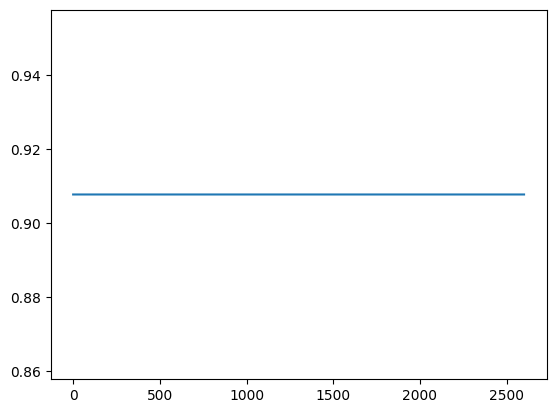

In [7]:
plt.plot(Ecohyd_model.mg.at_cell['rainfall__daily_depth'])

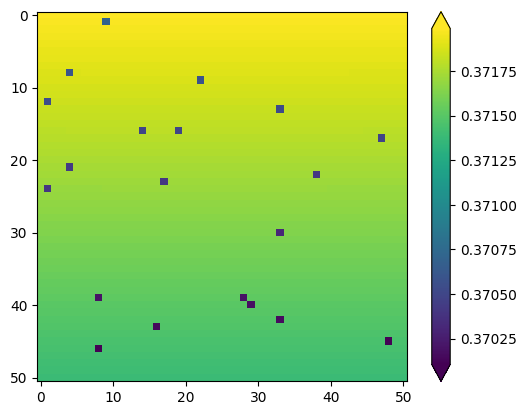

In [8]:
plt.imshow(np.reshape(Ecohyd_model.mg.at_cell['surface__evapotranspiration'], (51,51)))
plt.colorbar(extend = 'both')

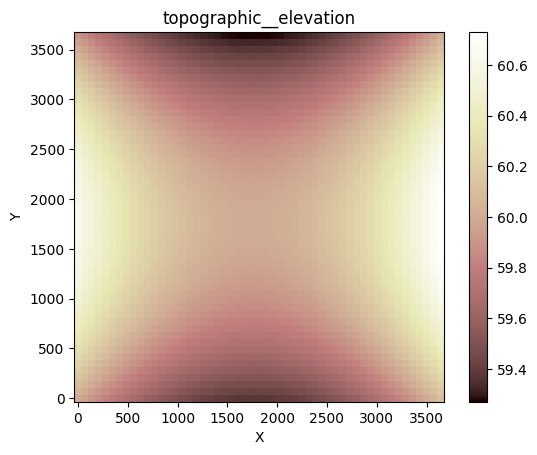

In [9]:
from landlab.plot.imshow import imshow_grid_at_node
#N.B. the Landlab user guide tells you to import the wrong component here

plt.figure('Elevations from the field')  # new fig, with a name
imshow_grid_at_node(Ecohyd_model.mg, 'topographic__elevation') 
plt.show()

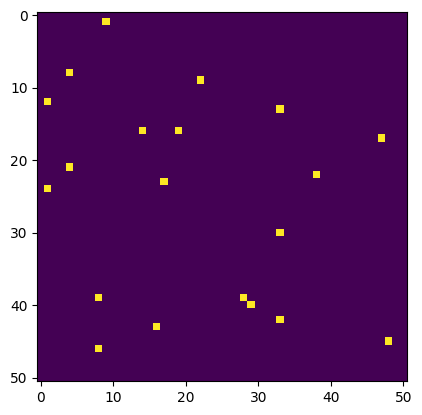

In [10]:
plt.imshow(WSA_array)

N.B the following images are all flipped upside-down because np.reshape assumes by default that the origin is in the top left, not the bottom left.

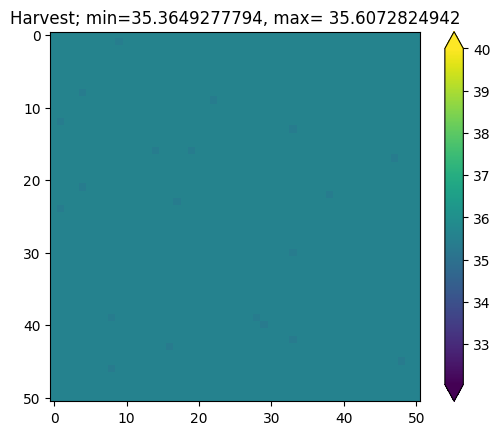

In [11]:
plt.imshow(np.reshape(biomass_harvest, (51,51)), vmin=40)
hmin = np.min(biomass_harvest)
hmax = np.max(biomass_harvest)
plt.title('Harvest; min='+str(hmin)+', max= ' + str(hmax))

plt.colorbar(extend = 'both')

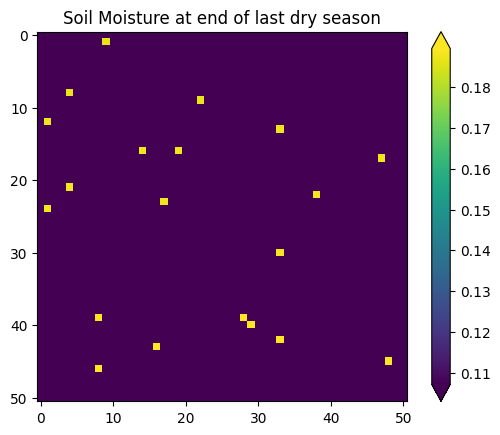

In [12]:
plt.imshow(np.reshape(SM_canic_end, (51,51)))
plt.title('Soil Moisture at end of last dry season')
plt.colorbar(extend = 'both')

Why does WSA decrease soil moisture? A bit sus... Maybe there is still enough rainfall that the cover crop interception leads to less SM.

Almost more importantly though, we need to figure out what causes the weird artifact at the bottom of the plot (i.e., the North of the domain). Why is soil moisture there so much lower? As-is, this will dominate any potential effects from WSA.

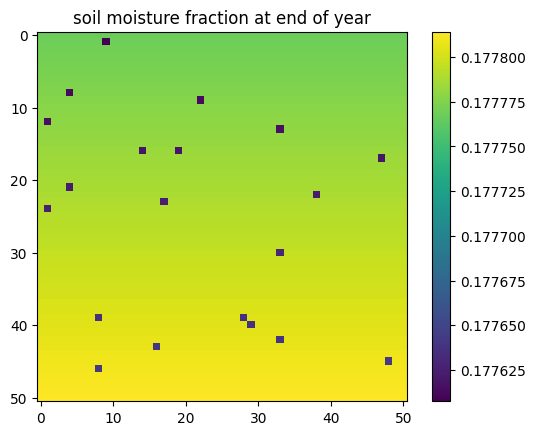

In [13]:
SM = np.reshape(Ecohyd_model.mg.at_cell['soil_moisture__saturation_fraction'], (51,51))
plt.imshow(SM)
plt.title('soil moisture fraction at end of year')
plt.colorbar()

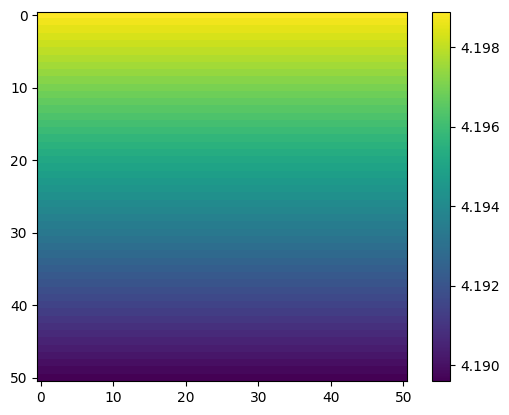

In [14]:
ET = np.reshape(Ecohyd_model.mg.at_cell['surface__potential_evapotranspiration_rate'], (51,51))
plt.imshow(ET)
plt.colorbar()

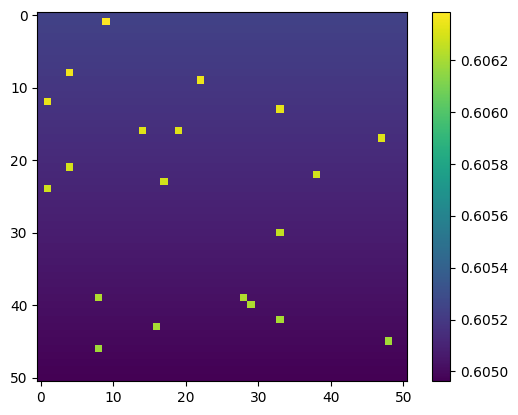

In [15]:
WS = np.reshape(Ecohyd_model.mg.at_cell['vegetation__water_stress'], (51,51))
plt.imshow(WS)
plt.colorbar()

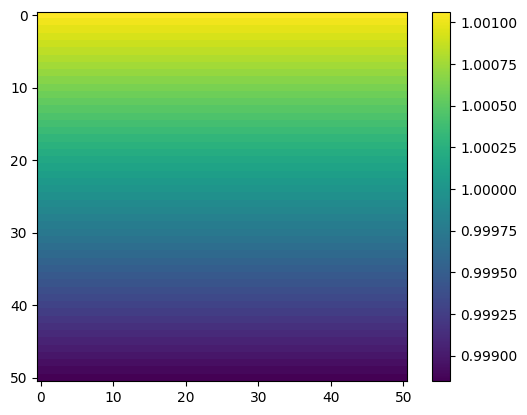

In [16]:
Rad_slope = np.reshape(Ecohyd_model.mg.at_cell['radiation__ratio_to_flat_surface'], (51,51))
plt.imshow(Rad_slope)
plt.colorbar()